<a href="https://colab.research.google.com/github/Wambui-123/Data-intergration/blob/main/Data_Intergration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, when, count, isnan, isnull, trim, lower, lit
from pyspark.sql.types import DoubleType, IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F

In [7]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CVD_Data_Engineering_Notebook") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Section 1: Data Ingestion

In [8]:
# Define the path to your dataset
file_path = "CVD_cleaned.csv"

In [9]:
# Load the dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [10]:
df.printSchema()

root
 |-- General_Health: string (nullable = true)
 |-- Checkup: string (nullable = true)
 |-- Exercise: string (nullable = true)
 |-- Heart_Disease: string (nullable = true)
 |-- Skin_Cancer: string (nullable = true)
 |-- Other_Cancer: string (nullable = true)
 |-- Depression: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Arthritis: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age_Category: string (nullable = true)
 |-- Height_(cm): double (nullable = true)
 |-- Weight_(kg): double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking_History: string (nullable = true)
 |-- Alcohol_Consumption: double (nullable = true)
 |-- Fruit_Consumption: double (nullable = true)
 |-- Green_Vegetables_Consumption: double (nullable = true)
 |-- FriedPotato_Consumption: double (nullable = true)



In [11]:
print(f"Number of records: {df.count()}")

Number of records: 308854


In [12]:
print("First row of the raw data:")
df.show(1, truncate=False)

First row of the raw data:
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|General_Health|Checkup                |Exercise|Heart_Disease|Skin_Cancer|Other_Cancer|Depression|Diabetes|Arthritis|Sex   |Age_Category|Height_(cm)|Weight_(kg)|BMI  |Smoking_History|Alcohol_Consumption|Fruit_Consumption|Green_Vegetables_Consumption|FriedPotato_Consumption|
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+-----------+-----------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+
|Poor          |Within the past 2 years|No      |No           |No         |No          |No        |No      |Yes      |Female|70-74       |150.0  

In [13]:
# Keeping a copy of the original DataFrame
df_raw = df

# Section 2: Data Preprocessing

In [14]:
# Renaming columns for easier access
cleaned_df = df

for column in cleaned_df.columns:
    new_column_name = column.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").lower()
    if new_column_name != column: # Only rename if there's a change
        cleaned_df = cleaned_df.withColumnRenamed(column, new_column_name)

In [15]:
cleaned_df.printSchema()

root
 |-- general_health: string (nullable = true)
 |-- checkup: string (nullable = true)
 |-- exercise: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- skin_cancer: string (nullable = true)
 |-- other_cancer: string (nullable = true)
 |-- depression: string (nullable = true)
 |-- diabetes: string (nullable = true)
 |-- arthritis: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age_category: string (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kg: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- alcohol_consumption: double (nullable = true)
 |-- fruit_consumption: double (nullable = true)
 |-- green_vegetables_consumption: double (nullable = true)
 |-- friedpotato_consumption: double (nullable = true)



In [16]:
# Handling Missing Values
for column in cleaned_df.columns:
    # For string columns, check for null and empty strings
    if cleaned_df.schema[column].dataType.simpleString() == "string":
        null_or_empty_count = cleaned_df.filter(col(column).isNull() | (trim(col(column)) == "")).count()
        if null_or_empty_count > 0:
            print(f"Column '{column}': {null_or_empty_count} missing values (null or empty string)")
    # For numeric columns, check for null and NaN (if applicable)
    elif cleaned_df.schema[column].dataType in [DoubleType(), IntegerType()]:
        null_count = cleaned_df.filter(col(column).isNull()).count()
        nan_count = cleaned_df.filter(isnan(col(column))).count()
        if null_count > 0 or nan_count > 0:
            print(f"Column '{column}': {null_count} nulls, {nan_count} NaNs")

In [17]:
# missing values imputation
imputer = Imputer(inputCols=["bmi"], outputCols=["bmi_imputed"]).setStrategy("mean")
cleaned_df = imputer.fit(cleaned_df).transform(cleaned_df)

In [18]:
# 2.3 Data Type Correction and Consistency
categorical_cols_to_standardize = [
    "general_health", "checkup", "exercise", "heart_disease", "skin_cancer",
    "other_cancer", "depression", "diabetes", "arthritis", "sex", "smoking_history"
]

In [19]:
for col_name in categorical_cols_to_standardize:
    if col_name in cleaned_df.columns: # Check if column exists after renaming
        cleaned_df = cleaned_df.withColumn(col_name, lower(trim(col(col_name))))

In [20]:
# 2.4 Filtering
initial_row_count = cleaned_df.count()

cleaned_df = cleaned_df.filter((col("bmi") >= 10) & (col("bmi") <= 60))

rows_after_bmi_filter = cleaned_df.count()

In [21]:
if initial_row_count - rows_after_bmi_filter > 0:
    print(f"Filtered out {initial_row_count - rows_after_bmi_filter} rows with unrealistic BMI values.")

Filtered out 562 rows with unrealistic BMI values.


In [22]:
print(f"Number of records after preprocessing: {cleaned_df.count()}")

Number of records after preprocessing: 308292


In [23]:
print("First row after preprocessing:")
cleaned_df.show(1, truncate=False)

First row after preprocessing:
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+---------+---------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+-----------+
|general_health|checkup                |exercise|heart_disease|skin_cancer|other_cancer|depression|diabetes|arthritis|sex   |age_category|height_cm|weight_kg|bmi  |smoking_history|alcohol_consumption|fruit_consumption|green_vegetables_consumption|friedpotato_consumption|bmi_imputed|
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+------+------------+---------+---------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+-----------+
|poor          |within the past 2 years|no      |no           |no         |no          |no        |no      |yes      

# Section 3: Data Integration and Transformation

In [24]:
# Feature Engineering
# Create 'bmi_category' from 'bmi'
transformed_df = cleaned_df.withColumn(
    "bmi_category",
    when(col("bmi") < 18.5, "underweight")
    .when((col("bmi") >= 18.5) & (col("bmi") < 24.9), "normal_weight")
    .when((col("bmi") >= 25.0) & (col("bmi") < 29.9), "overweight")
    .otherwise("obese")
)

In [25]:
# Converting 'yes'/'no' columns to binary
binary_cols_to_convert = [
    "exercise", "heart_disease", "skin_cancer", "other_cancer",
    "depression", "diabetes", "arthritis", "smoking_history"
]

In [26]:
for col_name in binary_cols_to_convert:
    if col_name in transformed_df.columns:
        transformed_df = transformed_df.withColumn(
            col_name,
            when(col(col_name) == "yes", 1).otherwise(0)
        )

In [27]:
# Convert 'sex' column to binary
if "sex" in transformed_df.columns:
    transformed_df = transformed_df.withColumn(
        "sex",
        when(col("sex") == "male", 1).otherwise(0)
    )

In [28]:
print("\nSchema after transformation and feature engineering:")
transformed_df.printSchema()


Schema after transformation and feature engineering:
root
 |-- general_health: string (nullable = true)
 |-- checkup: string (nullable = true)
 |-- exercise: integer (nullable = false)
 |-- heart_disease: integer (nullable = false)
 |-- skin_cancer: integer (nullable = false)
 |-- other_cancer: integer (nullable = false)
 |-- depression: integer (nullable = false)
 |-- diabetes: integer (nullable = false)
 |-- arthritis: integer (nullable = false)
 |-- sex: integer (nullable = false)
 |-- age_category: string (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kg: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_history: integer (nullable = false)
 |-- alcohol_consumption: double (nullable = true)
 |-- fruit_consumption: double (nullable = true)
 |-- green_vegetables_consumption: double (nullable = true)
 |-- friedpotato_consumption: double (nullable = true)
 |-- bmi_imputed: double (nullable = true)
 |-- bmi_category: string (nullable = fals

In [29]:
print(f"Number of records after transformation: {transformed_df.count()}")

Number of records after transformation: 308292


In [30]:
print("First row after transformation:")
transformed_df.show(1, truncate=False)

First row after transformation:
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+---+------------+---------+---------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+-----------+------------+
|general_health|checkup                |exercise|heart_disease|skin_cancer|other_cancer|depression|diabetes|arthritis|sex|age_category|height_cm|weight_kg|bmi  |smoking_history|alcohol_consumption|fruit_consumption|green_vegetables_consumption|friedpotato_consumption|bmi_imputed|bmi_category|
+--------------+-----------------------+--------+-------------+-----------+------------+----------+--------+---------+---+------------+---------+---------+-----+---------------+-------------------+-----------------+----------------------------+-----------------------+-----------+------------+
|poor          |within the past 2 years|0       |0            |0          |0          

# Section 4: ETL/ELT Pipeline

In [31]:
# Collect the Spark DataFrame to a Pandas DataFrame
pandas_df = transformed_df.toPandas()

In [32]:
# Define the output directory for Parquet files
output_parquet_file_pandas = "processed_cvd_data_single.parquet"

In [33]:
pandas_df.to_parquet(output_parquet_file_pandas, index=False)

In [34]:
print(f"Processed data saved successfully to '{output_parquet_file_pandas}' in Parquet format.")

Processed data saved successfully to 'processed_cvd_data_single.parquet' in Parquet format.


# Section 5: Analytics and Insights

In [35]:
# Register the DataFrame as a temporary SQL view for Spark SQL queries
transformed_df.createOrReplaceTempView("cvd_data")

In [36]:
# 1. Distribution of 'General_Health' status
spark.sql("SELECT general_health, COUNT(*) as count FROM cvd_data GROUP BY general_health ORDER BY count DESC").show()

+--------------+------+
|general_health| count|
+--------------+------+
|     very good|110331|
|          good| 95194|
|     excellent| 55923|
|          fair| 35613|
|          poor| 11231|
+--------------+------+



In [37]:
# 2. Average BMI by Heart Disease status
spark.sql("SELECT heart_disease, ROUND(AVG(bmi), 2) as avg_bmi FROM cvd_data GROUP BY heart_disease").show()

+-------------+-------+
|heart_disease|avg_bmi|
+-------------+-------+
|            1|  29.49|
|            0|  28.47|
+-------------+-------+



In [38]:
# Percentage of individuals exercising within each BMI category
spark.sql("""
    SELECT bmi_category,
           ROUND(AVG(exercise) * 100, 2) as percent_exercising,
           COUNT(*) as total_individuals_in_category
    FROM cvd_data
    GROUP BY bmi_category
    ORDER BY percent_exercising DESC
""").show()

+-------------+------------------+-----------------------------+
| bmi_category|percent_exercising|total_individuals_in_category|
+-------------+------------------+-----------------------------+
|normal_weight|             83.39|                        87610|
|   overweight|             80.57|                       107822|
|  underweight|             72.47|                         4537|
|        obese|             70.08|                       108323|
+-------------+------------------+-----------------------------+



In [39]:
# Total individuals diagnosed with Skin Cancer OR Other Cancer
spark.sql("""
    SELECT COUNT(*) as individuals_with_any_cancer
    FROM cvd_data
    WHERE skin_cancer = 1 OR other_cancer = 1
""").show()

+---------------------------+
|individuals_with_any_cancer|
+---------------------------+
|                      52840|
+---------------------------+



# Section 6: Visualization

/tmp/ipython-input-40-904932755.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='general_health', y='count', data=general_health_dist_pd, palette='viridis')


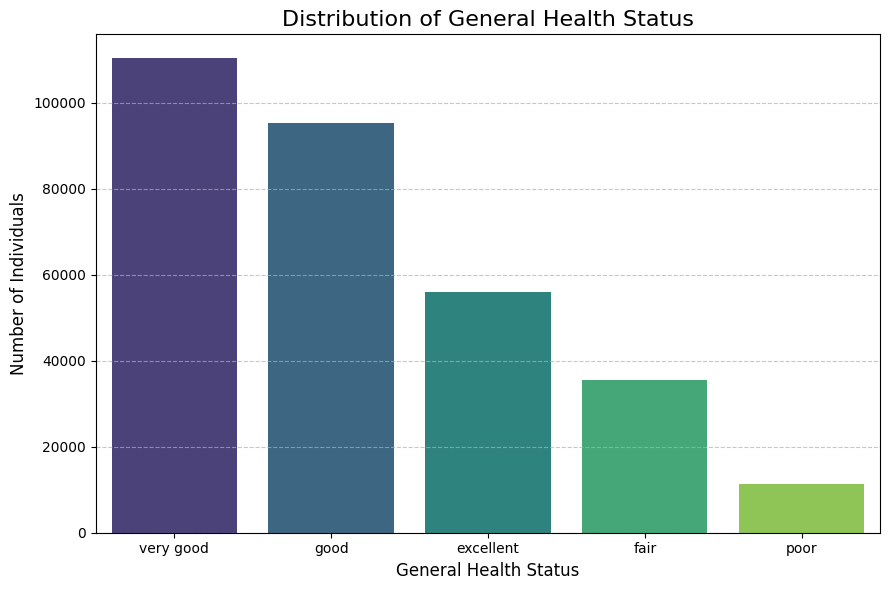

In [40]:
# Bar chart for General Health Distribution
general_health_dist_pd = transformed_df.groupBy("general_health").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(9, 6))
sns.barplot(x='general_health', y='count', data=general_health_dist_pd, palette='viridis')
plt.title('Distribution of General Health Status', fontsize=16)
plt.xlabel('General Health Status', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-41-1445899742.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bmi_category', y='avg_bmi', data=avg_bmi_by_category_pd, palette='plasma')


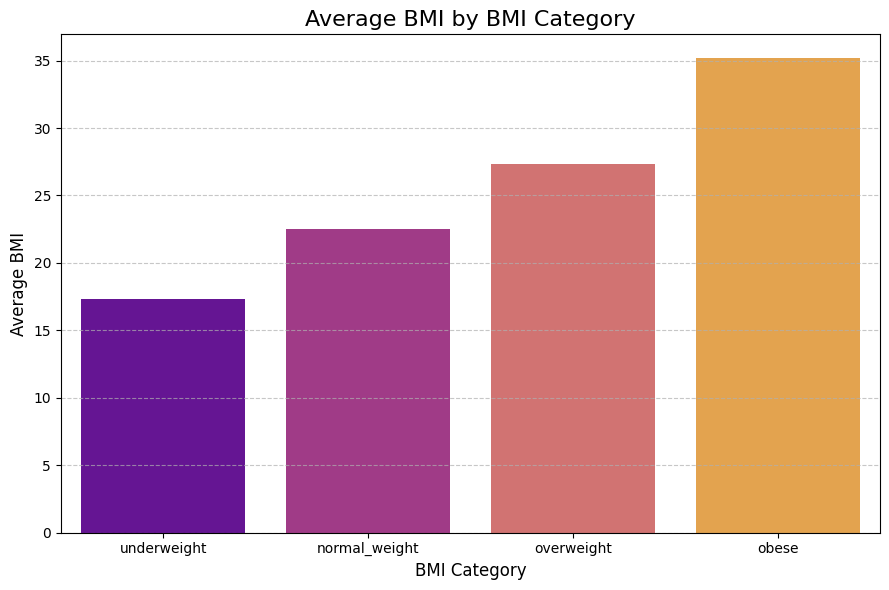

In [41]:
# Average BMI by BMI Category (Bar Chart)
avg_bmi_by_category_pd = transformed_df.groupBy("bmi_category").agg(round(avg("bmi"), 2).alias("avg_bmi")).toPandas()

# Define a specific order for BMI categories for logical display
bmi_order = ["underweight", "normal_weight", "overweight", "obese"]
avg_bmi_by_category_pd['bmi_category'] = pd.Categorical(avg_bmi_by_category_pd['bmi_category'], categories=bmi_order, ordered=True)
avg_bmi_by_category_pd = avg_bmi_by_category_pd.sort_values('bmi_category')

plt.figure(figsize=(9, 6))
sns.barplot(x='bmi_category', y='avg_bmi', data=avg_bmi_by_category_pd, palette='plasma')
plt.title('Average BMI by BMI Category', fontsize=16)
plt.xlabel('BMI Category', fontsize=12)
plt.ylabel('Average BMI', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

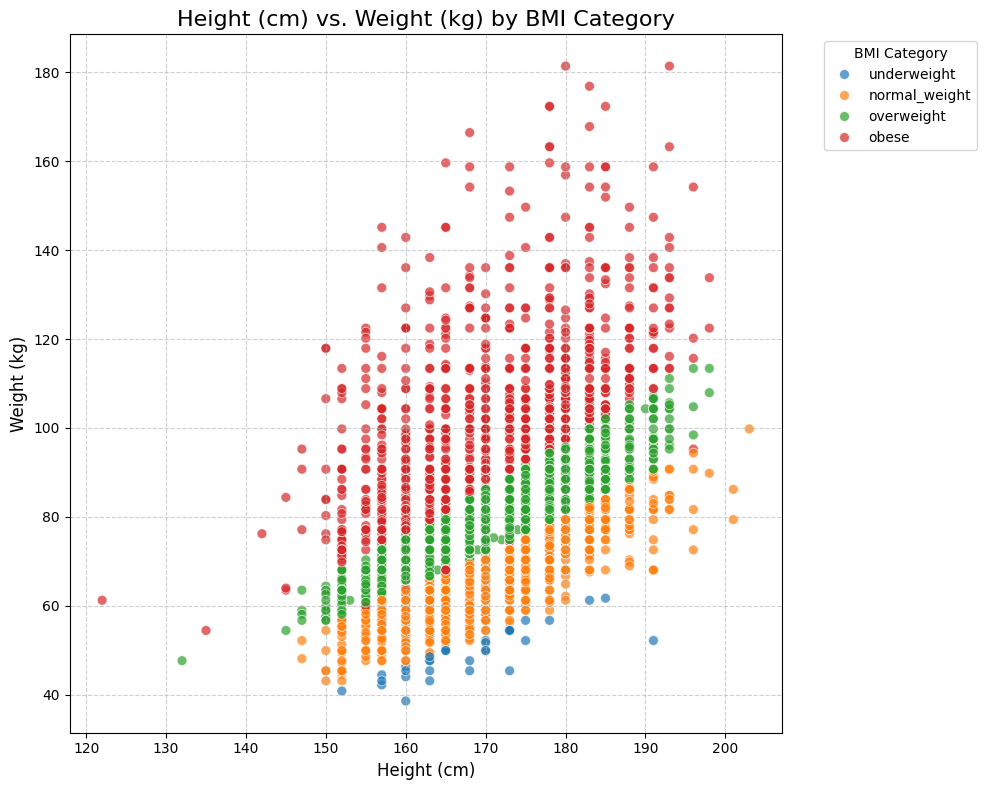

In [42]:
# Scatter Plot of Height vs. Weight, colored by BMI Category
sampled_data_for_scatter_pd = transformed_df.sample(False, 0.01, seed=42).limit(10000).toPandas()

if not sampled_data_for_scatter_pd.empty:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='height_cm', y='weight_kg', hue='bmi_category', data=sampled_data_for_scatter_pd,
                    palette='tab10', alpha=0.7, s=50,
                    hue_order=["underweight", "normal_weight", "overweight", "obese"]) # Ensure hue order
    plt.title('Height (cm) vs. Weight (kg) by BMI Category', fontsize=16)
    plt.xlabel('Height (cm)', fontsize=12)
    plt.ylabel('Weight (kg)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='BMI Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Sampled data for scatter plot is empty. Skipping scatter plot.")